# 1 Basic idea 


Based on:[Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672)


## 1.1 Repeatedly add Guassian noise (noise from a normal distribution)
- Add Gaussian noise repeatedly to an image 
 - Called a forward noising process
- If you do it frequently enough will end up with purely Gaussian noise (can be mathematically proven)

<img src="http://drive.google.com/uc?export=view&id=107XsECWx7oK4C6xJon9vUWsiGqGd-ezc" width=600 heigth=600>



## 1.2 Model to denoise back to (original) image 
- Task: If you give an image with some noise can you (the model) tell me what image (in the previouls noise step) it came from
- Key aspect 1: denoising done one step at a time
- Key aspect 2: same model repeatedly used for every step (given time step index as input as well)
- If you can do this for the full process you are able to generate images from Gaussian noise
- To do so model has to find out the noise in the image (added in the last step)
- Makes large set of high quality training data out of every image
- After training can sample noise from a random Gaussian distribution and get an image



## 1.3 Relationship to previouls models
- Like a GAN -> sampling from noise to get an image
- Like Denoising Autoencoder - > adds noise and noise has to be removed ( but not in a step by step manner) 
- Like VAE - Each step in the difffusion model is variational inference (many small steps of variational inference)


<img src="http://drive.google.com/uc?export=view&id=1ucQKiZWMkXeGDjgJtPjBG-fh4gMXDE0B" width=600 heigth=600>




#2 The details 

## 2.1 Forward noising process: Sampling from noise

<img src="http://drive.google.com/uc?export=view&id=1UuCLTICGpIpqfuZzGAIRFr6ydtU_-Xji" width=600 heigth=600>


Given a data distribution $x_0 \sim q\left(x_0\right)$, we define a forward noising process $q$ which produces latents $x_1$ through $x_T$ by adding Gaussian noise at time $t$ with variance $\beta_t \in(0,1)$ as follows:
$$
\begin{aligned}
q\left(x_1, \ldots, x_T \mid x_0\right) & :=\prod_{t=1}^T q\left(x_t \mid x_{t-1}\right) \\
q\left(x_t \mid x_{t-1}\right) & :=\mathcal{N}\left(x_t ; \sqrt{1-\beta_t} x_{t-1}, \beta_t \mathbf{I}\right)
\end{aligned}
$$

Given sufficiently large $T$ and a well behaved schedule of $\beta_t$, the latent $x_T$ is nearly an [isotropic Gaussian distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic).

Note that the above process is a **Markov Chain**

**Explanation 1..**
$$
\prod_{t=1}^T q\left(x_t \mid x_{t-1}\right)
$$
Means that given the original image $x_0$ the noised images at point $x_1$... $x_t$ are obtained by repeatedly applying the noising process (this process is multiplicative), that is one can obtain the next step by multiplying the previouls step with the result of noise that is drawn and multiplying it with another draw of noise and so on..


**Explanation 2**
$$
q\left(x_t \mid x_{t-1}\right):=\mathcal{N}\left(x_t ; \sqrt{1-\beta_t} x_{t-1}, \beta_t \mathbf{I}\right)
$$
Distribution of next sample   $x_t$ from the previouls sample $x_{t-1}$ is a normal distribution   $\mathcal{N}$  centered at (with mean) $\sqrt{1-\beta_t} x_{t-1}$ and variance $\beta_t \mathbf{I}$, which means that it is noise that has a diagonal covariance matrix



**Noise Schedule**

$$
\beta_t
$$
is chosen through a noise schedule that we will come back to later

**Scaling factor**
$$
\alpha_t =1-\beta_t
$$

is a scaling factor which gradually shrinks the mean towards zero

often rewritten as $$\alpha_t$$ for simplification




**Closed form solution**
For step ahead multiple time steps ahead in the noising process $\bar{\alpha}_t$  can be written as the cumulative product of the individual $\alpha$ 's

$$
\bar{\alpha}_t=\prod_{s=1}^t a_s
$$



**Closed form solution**
Instead of iteratively applying the noise image at a certain time step can also be derived in a closed form solution

$$
x_t=\sqrt{\bar{\alpha}_t} x_0+\sqrt{1-\bar{\alpha}_t} \epsilon
$$

This is important for coding efficiency, since it saves us from say, applying the same noising step 1000 times

**Sampling**

<img src="http://drive.google.com/uc?export=view&id=1QsDjyO9_bq97v4ViOFqqTeV4WsGVcIWB" width=600 heigth=600>



https://arxiv.org/pdf/2006.11239.pdf




## 2.2 Backward process

Thus, if we know the exact reverse distribution $q\left(x_{t-1} \mid x_t\right)$, we can sample $x_T \sim \mathcal{N}(0, \mathrm{I})$ and run the process in reverse to get a sample from $q\left(x_0\right)$. However, since $q\left(x_{t-1} \mid x_t\right)$ depends on the entire data distribution, we approximate it using a neural network as follows:
$$
p_\theta\left(x_{t-1} \mid x_t\right):=\mathcal{N}\left(x_{t-1} ; \mu_\theta\left(x_t, t\right), \Sigma_\theta\left(x_t, t\right)\right)
$$


**Explanation 1: Why does the revers distribution depend on the entire dataset**
Answer- Because to figure out what the noise part is you need to figure out the original underlying distribution of real images is

Give me a distribution over images where this could have come from

NN will produce mean and covariance matrix of the noise given the image

What is the gaussian distribution of images where this came from

## 2.2 Loss function and relationship to variantional auto encoders
(no need to understand details of math here)
The combination of $q$ and $p$ is a variational auto-encoder (Kingma \& Welling, 2013), and we can write the variational lower bound (VLB) as follows:
$$
\begin{aligned}
L_{\mathrm{vlb}} & :=L_0+L_1+\ldots+L_{T-1}+L_T \\
L_0 & :=-\log p_\theta\left(x_0 \mid x_1\right) \\
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
L_T & :=D_{K L}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)
\end{aligned}
$$

...Like many mini step variational auto-encoders

**Explanation**
$$
\begin{aligned}
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
\end{aligned}
$$

distribution that the neural network outputs: 
$$p_\theta\left(x_{t-1} \mid x_t\right)$$

match with what it actually is:
$$q\left(x_{t-1} \mid x_t, x_0\right)$$



### 2.2.1 The Loss

There are different objectives one could apply (see paper), but the objective of predicting where the noise is seems to be most effective.

So all of the above tanslates in the simple loss function:
$$
L_{\text {simple }}=E_{t, x_0, \epsilon}\left[\left\|\epsilon-\epsilon_\theta\left(x_t, t\right)\right\|^2\right]
$$

In the original paper the loss is also combined with an importance sampling scheme, as the earlier steps of the noise diffusion add much more loss than the previous steps




**Explanation**

All this requires to predict he noise for every pixel and the be take the L2 norm between the predicted noise and the actual noise and average over it

note that I am leaving out some important details about the loss here for simplification. To see these details, havea look at the original paper referenced at the beginning



# 2.3 The Neural Network


The original model has a UNet achrchitecture 


<img src="http://drive.google.com/uc?export=view&id=1Jm18gyEHXxr0iiF0DOGGYKrm3szA9lYP" width=600 heigth=600>


- see [here:](https://paperswithcode.com/method/u-net)


## 2.4 Training

<img src="http://drive.google.com/uc?export=view&id=1EbnLt-swQV7wlNZGRzL_17kRFh4Rz4hO" width=600 heigth=600>


https://arxiv.org/pdf/2006.11239.pdf




# 3 Noise Schedule 
Set a cosine schedule so that noise is added faster at the beginning and more slowly at the end

On the following picture the top is the linear noise schedule and the bottom is the cosine noise schedule

<img src="http://drive.google.com/uc?export=view&id=19vr1NTVF9LR33l5MgSgLCID93RkjBMUn" width=600 heigth=600>



And the Friched inception score and fraction of diffusion process skipped

<img src="http://drive.google.com/uc?export=view&id=11a7PPp3JoGJFsIhYfma-AvlHsoWL1-Sk" width=600 heigth=600>

Note that this analysis does not constiture super strong evidence


# 4 Classifier Guidance / conditioning

Based on: [Diffusion Models beat gans on image Synthesis](https://arxiv.org/abs/2105.05233)

- Use model for conditional image generation
- Use Classifier to improve diffusion generator

 - Pre-trained diffusion model can be conditioned using the gradients of a classifier
 - In particular, we can train a classifier $p_\phi\left(y \mid x_t, t\right)$ on noisy images $x_t$, and then use gradients $\nabla_{x_t} \log p_\phi\left(y \mid x_t, t\right)$ to guide the diffusion sampling process towards an arbitrary class label $y$.

Instead of simply reverting the noise process if the model is told what label that image is from/ what class the image is from, can it do a better job

To condition on y

$$
p_{\theta, \phi}\left(x_t \mid x_{t+1}, y\right)=Z p_\theta\left(x_t \mid x_{t+1}\right) p_\phi\left(y \mid x_t\right)
$$

where Z is a normalizing constant

and the right term
$$p_\phi\left(y \mid x_t\right)$$ is the classifier


Note that the the "descriminator" is activ at every step here.


<img src="http://drive.google.com/uc?export=view&id=1jIN-Gi5BDPXcoO2kDGDHQDI859x4zaD_" width=600 heigth=600>


# 5 Why diffusion models (may be) more effective than GANS

**Advantages of diffusion models**
- Smaller steps more iterative guided process from noise to Image
- Does not suffer from the usual GAN convergence difficulties: Minimizing the loss will generally help, no competitive game theory settings
- As a result of more detailed guidance no problems with mode collaps in the sense of outputting a bogus image that convinces the discriminator
- But still have to make sure that the whole space of sampled e.g. through conditioning

**Disadvantages of diffusion models**
- Slow generation process due to the high number of iterative steps
- No dimensionality reduction





Some results for diffusion models, in this case from Midjourney

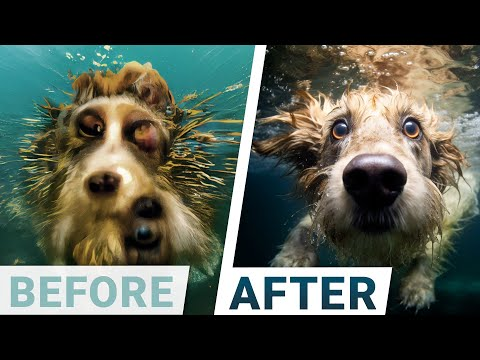

In [ ]:
from IPython.display import YouTubeVideo

# Create a YouTubeVideo instance with the video ID.
video = YouTubeVideo("twKgWGmsBLY")

# Display the video.
display(video)

# Follow-up reads

Note that the DDPM paper showed that diffusion models are a promising direction for (un)conditional image generation. This has since then (immensely) been improved, most notably for text-conditional image generation. Below, we list some important (but far from exhaustive) follow-up works:

- Improved Denoising Diffusion Probabilistic Models ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672)): finds that learning the variance of the conditional distribution (besides the mean) helps in improving performance
- Cascaded Diffusion Models for High Fidelity Image Generation ([Ho et al., 2021](https://arxiv.org/abs/2106.15282)): introduce cascaded diffusion, which comprises a pipeline of multiple diffusion models that generate images of increasing resolution for high-fidelity image synthesis
- Diffusion Models Beat GANs on Image Synthesis ([Dhariwal et al., 2021](https://arxiv.org/abs/2105.05233)): show that diffusion models can achieve image sample quality superior to the current state-of-the-art generative models by improving the U-Net architecture, as well as introducing classifier guidance
- Classifier-Free Diffusion Guidance ([Ho et al., 2021](https://openreview.net/pdf?id=qw8AKxfYbI)): shows that you don't need a classifier for guiding a diffusion model by jointly training a conditional and an unconditional diffusion model with a single neural network
- Hierarchical Text-Conditional Image Generation with CLIP Latents (DALL-E 2) ([Ramesh et al., 2022](https://cdn.openai.com/papers/dall-e-2.pdf)): use a prior to turn a text caption into a CLIP image embedding, after which a diffusion model decodes it into an image
- Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding (ImageGen) ([Saharia et al., 2022](https://arxiv.org/abs/2205.11487)): shows that combining a large pre-trained language model (e.g. T5) with cascaded diffusion works well for text-to-image synthesis

Note that this list only includes important works until the time of writing, which is June 7th, 2022.

For now, it seems that the main (perhaps only) disadvantage of diffusion models is that they require multiple forward passes to generate an image (which is not the case for generative models like GANs). However, there's [research going on](https://arxiv.org/abs/2204.13902) that enables high-fidelity generation in as few as 10 denoising steps.

Further Reading:
1. Paper: https://arxiv.org/pdf/1503.03585.pdf
2. Paper: https://arxiv.org/pdf/2006.11239.pdf
3. Paper: https://arxiv.org/pdf/2102.09672.pdf
4. Paper: https://arxiv.org/pdf/2105.05233.pdf
5. CFG: https://arxiv.org/pdf/2207.12598.pdf
6. Timestep Embedding: https://machinelearningmastery.com/a-


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)
